# House Prices Initial Exploration

I have switched to a second notebook since the first got really messy

https://www.kaggle.com/c/house-prices-advanced-regression-techniques


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from autogluon.tabular import TabularDataset, TabularPredictor


## Read Data

In [2]:
df_train = pd.read_csv('../data/raw/train.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Some settings

In [4]:
# change number of rows/columns we will view
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

## Going Log

Since the goal is to predict the log of sales price, let's convert that right away

In [5]:
# df_train['LogSalePrice']= np.log(df_train['SalePrice'])
df_train['SalePrice']= np.log(df_train['SalePrice'])


# Find the NaN

Fix NaN values early

Dataset is clean so this is fairly easy

In [6]:
# Find columns containing NaN values
columns_with_nan = df_train.columns[df_train.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", columns_with_nan)
print('                   ')
print('that is ' + str(len(columns_with_nan)) + ' columns')

# Count NaN values in each column
nan_counts = df_train.isna().sum()

# Print the counts of NaN values in each column
print("NaN Value Counts in Each Column:")
print(nan_counts)

Columns with NaN values: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
                   
that is 19 columns
NaN Value Counts in Each Column:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [7]:
for column in columns_with_nan:
    print(df_train[column].value_counts())

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix        

In [7]:
df_train['GarageArea'].value_counts()

0      81
440    49
576    47
240    38
484    34
       ..
320     1
594     1
831     1
878     1
192     1
Name: GarageArea, Length: 441, dtype: int64

In [8]:
# Several features seem really easily fillable
# Categoricals that seem to be NaN because that feature is not on property
# often are other columns that verify this assumption (such as area = 0)

easy_fix_cols = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',  'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Replace NaN values in the categorical column with 'noFeature'
replacement_value = 'noFeature'
for col in easy_fix_cols:
    df_train[col] = df_train[col].fillna(replacement_value)

In [9]:
# MasVnrArea has some weird missing values

# Find the indices of NaN entries in the 'MasVnrArea' column
column_name = 'MasVnrArea'
nan_indices = df_train[df_train[column_name].isna()].index

# Print the values in the 'MasVnrType' column for the specified indices
column_name = 'MasVnrType'
values_for_indices = df_train.loc[nan_indices, column_name]
print("Values in the 'MasVnrType' column for the specified indices:")
print(values_for_indices)


Values in the 'MasVnrType' column for the specified indices:
234     noFeature
529     noFeature
650     noFeature
936     noFeature
973     noFeature
977     noFeature
1243    noFeature
1278    noFeature
Name: MasVnrType, dtype: object


From above, we see that all missing values of MasVnrArea are in houses with no masonry veneer.  So we can safely make them 0

In [10]:
# Set the values in the 'MasVnrArea' column for the specified indices to 0
column_name = 'MasVnrArea'
df_train.loc[nan_indices, column_name] = 0

In [11]:
# now check that the replacements worked

# Find columns containing NaN values
columns_with_nan = df_train.columns[df_train.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", columns_with_nan)
print('                   ')
print('that is ' + str(len(columns_with_nan)) + ' columns')


Columns with NaN values: ['LotFrontage', 'Electrical', 'GarageYrBlt']
                   
that is 3 columns


## weirdest NaN

There are 3 remaining features with NaN values: LotFrontage, Electrical, and GarageYrBlt

Missing LotFrontage is either because lot has no connection to street, or measurement wasn't take.  We will assume the former and replace LotFrontage missing values with 0.

Will replace Electrical missing value (it's only one) with most common value

Will drop GarageYrBlt for now because idk what to replace that value with (it's where there is no garage); I think this should be okay because there is big correlation with Year built and the other garage variables

In [12]:
# meanLotFrontage = df_train['LotFrontage'].mean()
# df_train['LotFrontage'] = df_train['LotFrontage'].fillna(meanLotFrontage)
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(0)

most_common_value = df_train['Electrical'].value_counts().idxmax()
df_train['Electrical'] = df_train['Electrical'].fillna(most_common_value)


In [13]:
# now check that the replacements worked

# Find columns containing NaN values
columns_with_nan = df_train.columns[df_train.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", columns_with_nan)
print('                   ')
print('that is ' + str(len(columns_with_nan)) + ' columns')

Columns with NaN values: ['GarageYrBlt']
                   
that is 1 columns


# Baseline Models

Begin by throwing everything at the model

## Convert Categorical to Dummy

In [15]:
# list of categorical and numerical variables
cat_cols = df_train.select_dtypes(include = ['object']).columns
num_cols = df_train.select_dtypes(include = ['int64', 'float64']).columns
print('there are ' + str(len(cat_cols)) + ' categorical variables')
print('there are ' + str(len(num_cols)) + ' numerical variables')

there are 43 categorical variables
there are 39 numerical variables


In [16]:
# Apply one-hot encoding to the categorical columns
df_encoded = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)

Now we can train the model on all variables (except GarageYrBlt for now)

In [53]:
# features and response vars
# dropping GarageYrBlt because idk what to do with missing values
X = df_encoded.drop(columns = ['SalePrice', 'LogSalePrice', 'GarageYrBlt', 'Id'])
y = df_encoded['LogSalePrice']

In [18]:
df_encoded.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,...,False,False,False,True,False
1,2,20,80.0,9600,6,...,False,False,False,True,False
2,3,60,68.0,11250,7,...,False,False,False,True,False
3,4,70,60.0,9550,7,...,False,False,False,False,False
4,5,60,84.0,14260,8,...,False,False,False,True,False


## All Features

## Linear Model

In [29]:
# goal of project is measured in RMSE
# Define a custom RMSE scoring function
def rmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

In [24]:
# Create a LinearRegression model
model = LinearRegression()

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10 , shuffle=True, random_state=42) # excluding some parameters

# Perform cross-validation
# scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(rmse_scorer, greater_is_better=False))
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Display the cross-validation results
print("Cross-Validation RMSE Scores:", scores)
print("Mean RMSE Score:", scores.mean())

Cross-Validation RMSE Scores: [-0.01573318 -0.06884912 -0.01225426 -0.03227351 -0.0733995  -0.02126471
 -0.05969498 -0.0286174  -0.01812929 -0.05999656]
Mean RMSE Score: -0.03902125104956101


In [25]:
X.shape

(1460, 258)

## CV Random Forest

In [29]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=make_scorer(rmse_scorer, greater_is_better=False))

# Display the cross-validation results
print("Cross-Validation RMSE Scores:", cross_val_scores)
print("Mean RMSE Score:", np.mean(cross_val_scores))

Cross-Validation RMSE Scores: [-0.13736449 -0.16212022 -0.113248   -0.14067342 -0.17257835 -0.15974991
 -0.1697204  -0.12815163 -0.14345947 -0.0960964 ]
Mean RMSE Score: -0.14231622821773068


## Backward Stepping Feature Selection

## Linear Model Feature Selection

In [88]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450,...,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,...,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,...,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,...,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,...,2008,WD,Normal,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,...,2007,WD,Normal,175000,12.072541
1456,1457,20,RL,85.0,13175,...,2010,WD,Normal,210000,12.254863
1457,1458,70,RL,66.0,9042,...,2010,WD,Normal,266500,12.493130
1458,1459,20,RL,68.0,9717,...,2010,WD,Normal,142125,11.864462


In [41]:
min_features_to_select = 5  # Minimum number of features to consider
# model_type = LinearRegression()
model_type = RandomForestRegressor(random_state=42)
# model_type = Lasso(alpha = 0.05)

cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

rfecv = RFECV(
    estimator=model_type,
    step=1,
    cv=cv,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    min_features_to_select=min_features_to_select,
    n_jobs=1,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 23


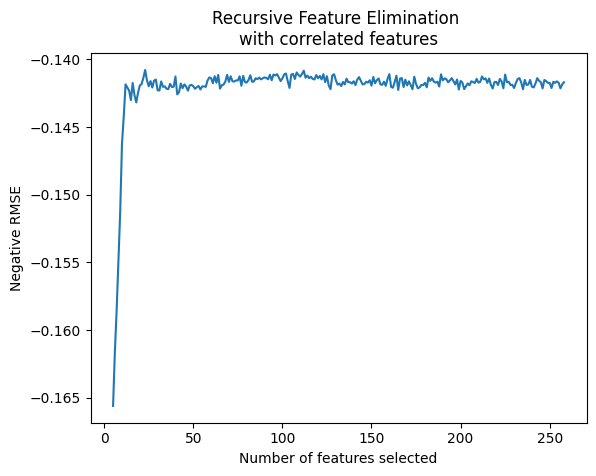

In [42]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Negative RMSE")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    #yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
# ax = plt.gca()
# ax.set_ylim([-10, 1])
plt.show()

In [43]:
rfecv.cv_results_["mean_test_score"]

array([-0.16560338, -0.16163015, -0.15853396, -0.15479485, -0.15126468,
       -0.14622849, -0.14419717, -0.14185194, -0.14208788, -0.14230925,
       -0.14301208, -0.14174956, -0.14264168, -0.14318387, -0.1424759 ,
       -0.14193466, -0.14182664, -0.1413694 , -0.14078377, -0.14154418,
       -0.14198861, -0.14160613, -0.14208442, -0.14157419, -0.14149654,
       -0.14229445, -0.14230051, -0.14163434, -0.14203071, -0.14200128,
       -0.14217429, -0.14219421, -0.14180872, -0.14204794, -0.14202489,
       -0.1412694 , -0.14258745, -0.14243043, -0.14178831, -0.14212936,
       -0.14185601, -0.14200807, -0.14231547, -0.14192899, -0.14188663,
       -0.14199062, -0.14217892, -0.14205405, -0.14196857, -0.14222724,
       -0.14200734, -0.1419972 , -0.14203571, -0.14156579, -0.14134049,
       -0.14139157, -0.1417698 , -0.14124809, -0.14172889, -0.14115213,
       -0.14216362, -0.1419136 , -0.14186818, -0.14163812, -0.14114404,
       -0.14166844, -0.14125227, -0.14162768, -0.14163805, -0.14

In [1]:
rfecv

NameError: name 'rfecv' is not defined

## Autogluon


First just see what happens with absolutely no treatment of anything

In [20]:
train_data = TabularDataset('../data/raw/train.csv')

Loaded data from: ../data/raw/train.csv | Columns = 81 / 81 | Rows = 1460 -> 1460


In [21]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,...,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,...,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,...,12,2008,WD,Normal,250000


In [22]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [38]:
# CV of raw data, no fixin'

# import data
rawTrain = pd.read_csv('../data/raw/train.csv')

# convert SalePrice to log
rawTrain['SalePrice'] = np.log(rawTrain['SalePrice'])

# Define the number of folds for cross-validation
num_folds = 10

# Calculate the number of samples and the size of each fold
num_samples = len(rawTrain)
fold_size = num_samples // num_folds

# Initialize lists to store the train and test data
rmse_list = []

# Iterate through the folds
for fold in range(num_folds):
    # Calculate the start and end indices for the test set
    start = fold * fold_size
    end = (fold + 1) * fold_size if fold < num_folds - 1 else num_samples

    # Use the current fold for testing and the rest for training
    tempTest = rawTrain.iloc[start:end, :]  # Slice the DataFrame
    tempTrain = pd.concat([rawTrain.iloc[:start, :], rawTrain.iloc[end:, :]])  # Concatenate DataFrames

    # convert to Tabular Datasets
    tempTest = TabularDataset(tempTest)
    tempTrain = TabularDataset(tempTrain)

    # fit predictor
    tempPredictor = TabularPredictor(label='SalePrice').fit(tempTrain)

    # find RMSE of logs
    rmse = tempPredictor.evaluate(tempTest, silent=True)['root_mean_squared_error']
    
    rmse_list.append(rmse)

# find CV mean of rmse
print('CV mean is ' + str(sum(rmse_list) / len(rmse_list)))

No path specified. Models will be saved in: "AutogluonModels/ag-20231104_015137/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231104_015137/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.42 GB / 250.69 GB (7.3%)
Train Data Rows:    146
Train Data Columns: 80
Label Column: SalePrice
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (12.991753427493052, 10.596634733096073, 11.99881, 0.37896)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feat

[1000]	valid_set's rmse: 0.163646


	-0.165	 = Validation score   (-root_mean_squared_error)
	0.37s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1769	 = Validation score   (-root_mean_squared_error)
	0.67s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1926	 = Validation score   (-root_mean_squared_error)
	7.83s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1905	 = Validation score   (-root_mean_squared_error)
	0.59s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1733	 = Validation score   (-root_mean_squared_error)
	1.78s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1568	 = Validation score   (-root_mean_squared_error)
	0.44s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1379	 = Validation score   (-root_mean_squared_error)
	2.24s	 = Training   runtime
	0.04s	 = Validation runti

[1000]	valid_set's rmse: 0.192898


Fitting model: WeightedEnsemble_L2 ...
	-0.1472	 = Validation score   (-root_mean_squared_error)
	0.39s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 31.81s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231104_015607/")
No path specified. Models will be saved in: "AutogluonModels/ag-20231104_015639/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231104_015639/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.38 GB / 250.69 GB (7.3%)
Train Data Rows:    146
Train Data Columns: 80
Label Column: SalePrice
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == flo

[1000]	valid_set's rmse: 0.141685


	-0.1417	 = Validation score   (-root_mean_squared_error)
	0.98s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1204	 = Validation score   (-root_mean_squared_error)
	0.4s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 27.3s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231104_015639/")
No path specified. Models will be saved in: "AutogluonModels/ag-20231104_015706/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231104_015706/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.37 GB / 250.69 GB (7.3%)
Train Data Rows:    146
Train Data Columns: 80
Label Column: SalePrice
Prep

[1000]	valid_set's rmse: 0.214605


	-0.2353	 = Validation score   (-root_mean_squared_error)
	0.36s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2411	 = Validation score   (-root_mean_squared_error)
	0.65s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-0.2283	 = Validation score   (-root_mean_squared_error)
	29.21s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2369	 = Validation score   (-root_mean_squared_error)
	0.58s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1586	 = Validation score   (-root_mean_squared_error)
	1.76s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2406	 = Validation score   (-root_mean_squared_error)
	0.47s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.2366	 = Validation score   (-root_mean_squared_error)
	1.69s	 = Training   runtime
	0.04s	 = Validation run

[1000]	valid_set's rmse: 0.19859
[2000]	valid_set's rmse: 0.198358


	-0.1984	 = Validation score   (-root_mean_squared_error)
	1.55s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1542	 = Validation score   (-root_mean_squared_error)
	0.39s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 38.65s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231104_015706/")
No path specified. Models will be saved in: "AutogluonModels/ag-20231104_015745/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231104_015745/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.35 GB / 250.69 GB (7.3%)
Train Data Rows:    146
Train Data Columns: 80
Label Column: SalePrice
Pr

[1000]	valid_set's rmse: 0.236919
[2000]	valid_set's rmse: 0.236785
[3000]	valid_set's rmse: 0.236777
[4000]	valid_set's rmse: 0.236777
[5000]	valid_set's rmse: 0.236777
[6000]	valid_set's rmse: 0.236777
[7000]	valid_set's rmse: 0.236777
[8000]	valid_set's rmse: 0.236777
[9000]	valid_set's rmse: 0.236777
[10000]	valid_set's rmse: 0.236777


	-0.2368	 = Validation score   (-root_mean_squared_error)
	5.49s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.179	 = Validation score   (-root_mean_squared_error)
	0.38s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 20.98s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231104_015745/")
No path specified. Models will be saved in: "AutogluonModels/ag-20231104_015807/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231104_015807/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.33 GB / 250.69 GB (7.3%)
Train Data Rows:    146
Train Data Columns: 80
Label Column: SalePrice
Pre

[1000]	valid_set's rmse: 0.124664
[2000]	valid_set's rmse: 0.124652
[3000]	valid_set's rmse: 0.124652
[4000]	valid_set's rmse: 0.124652
[5000]	valid_set's rmse: 0.124652
[6000]	valid_set's rmse: 0.124652
[7000]	valid_set's rmse: 0.124652
[8000]	valid_set's rmse: 0.124652
[9000]	valid_set's rmse: 0.124652
[10000]	valid_set's rmse: 0.124652


	-0.1247	 = Validation score   (-root_mean_squared_error)
	5.06s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.087	 = Validation score   (-root_mean_squared_error)
	0.37s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 210.26s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231104_015818/")


CV mean is -0.08651569308481755


In [3]:
# attempting to re-use the trained models

myPred = TabularPredictor.load(path = 'AutogluonModels/ag-20231104_015137')

In [4]:
# import data
rawTrain = pd.read_csv('../data/raw/train.csv')

# convert SalePrice to log
rawTrain['SalePrice'] = np.log(rawTrain['SalePrice'])

myTest = TabularDataset(rawTrain.iloc[:146,:])
myPred.evaluate(myTest, silent = True)


{'root_mean_squared_error': -0.07618667965781836,
 'mean_squared_error': -0.005804410157283033,
 'mean_absolute_error': -0.04284989944983148,
 'r2': 0.9593045798390804,
 'pearsonr': 0.981439348476447,
 'median_absolute_error': -0.026794163151611095}

In [6]:
# rechecking CV (models saved in files, must load)
path_list = [
    'ag-20231104_015137',
    'ag-20231104_015255',
    'ag-20231104_015532',
    'ag-20231104_015549',
    'ag-20231104_015607',
    'ag-20231104_015639',
    'ag-20231104_015706',
    'ag-20231104_015745',
    'ag-20231104_015807',
    'ag-20231104_015818'
]

# Define the number of folds for cross-validation
num_folds = 10

# Calculate the number of samples and the size of each fold
num_samples = len(rawTrain)
fold_size = num_samples // num_folds

# Initialize lists to store the train and test data
rmse_list = []

# Iterate through the folds
for fold in range(num_folds):
    # Calculate the start and end indices for the test set
    start = fold * fold_size
    end = (fold + 1) * fold_size if fold < num_folds - 1 else num_samples

    # get test data
    myTest = TabularDataset(rawTrain.iloc[start:end,:])

    # Load predictor
    myPath = 'AutogluonModels/' + path_list[fold]
    myPred = TabularPredictor.load(path = myPath)

    # evaluate predictor on test data
    rmse = myPred.evaluate(myTest, silent = True)['root_mean_squared_error']
    
    rmse_list.append(rmse)

# find CV mean of rmse
print('CV mean is ' + str(sum(rmse_list) / len(rmse_list)))

CV mean is -0.08651569308481755


In [7]:
rmse_list

[-0.07618667965781836,
 -0.06236001709453796,
 -0.07094164376511249,
 -0.09975584200406108,
 -0.07775805295525264,
 -0.06411676801919394,
 -0.08210614977221033,
 -0.09029345587155786,
 -0.18313131662799462,
 -0.05850700508043615]

In [65]:
tab_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450,...,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,...,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,...,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,...,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,...,2008,WD,Normal,250000,12.429216


In [59]:
# Create train/test splits for CV


# Define the number of folds for cross-validation
num_folds = 10

# Calculate the number of samples and the size of each fold
num_samples = len(X)
fold_size = num_samples // num_folds

# Initialize lists to store the train and test data
train_data = []
test_data = []

# Convert the pandas Series to a numpy array
# y = y.values

# Iterate through the folds
for fold in range(num_folds):
    # Calculate the start and end indices for the test set
    start = fold * fold_size
    end = (fold + 1) * fold_size if fold < num_folds - 1 else num_samples

    # Use the current fold for testing and the rest for training
    test_X = X.iloc[start:end, :]  # Slice the DataFrame
    test_y = y.iloc[start:end]
    train_X = pd.concat([X.iloc[:start, :], X.iloc[end:, :]])  # Concatenate DataFrames
    train_y = pd.concat([y[:start], y[end:]])

    train_data.append((train_X, train_y))
    test_data.append((test_X, test_y))

# Now you have the train and test data for each fold in the train_data and test_data lists, with X as a pandas DataFrame and y as a pandas Series.


In [66]:
predictor = TabularPredictor(label='SalePrice').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20231103_231823/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231103_231823/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.41 GB / 250.69 GB (7.3%)
Train Data Rows:    1460
Train Data Columns: 80
Label Column: SalePrice
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (755000, 34900, 180921.19589, 79442.50288)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to 

[1000]	valid_set's rmse: 27505.1
[2000]	valid_set's rmse: 27240.4
[3000]	valid_set's rmse: 27201.5
[4000]	valid_set's rmse: 27197.3
[5000]	valid_set's rmse: 27197.2


	-27196.7065	 = Validation score   (-root_mean_squared_error)
	6.32s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 29499.8
[2000]	valid_set's rmse: 28896.4
[3000]	valid_set's rmse: 28752.1
[4000]	valid_set's rmse: 28705.7
[5000]	valid_set's rmse: 28695.2
[6000]	valid_set's rmse: 28693
[7000]	valid_set's rmse: 28692.5
[8000]	valid_set's rmse: 28692.3
[9000]	valid_set's rmse: 28692.3
[10000]	valid_set's rmse: 28692.3


	-28692.2871	 = Validation score   (-root_mean_squared_error)
	16.54s	 = Training   runtime
	0.58s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-32782.873	 = Validation score   (-root_mean_squared_error)
	2.9s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost ...
	-28465.6966	 = Validation score   (-root_mean_squared_error)
	203.13s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-32047.6167	 = Validation score   (-root_mean_squared_error)
	1.62s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-34153.0592	 = Validation score   (-root_mean_squared_error)
	4.28s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-27778.2437	 = Validation score   (-root_mean_squared_error)
	3.45s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-35377.4685	 = Validation score   (-root_mean_squared_error)
	5.06s	 = Training   runt

[1000]	valid_set's rmse: 32134.9
[2000]	valid_set's rmse: 32087.8
[3000]	valid_set's rmse: 32084.2
[4000]	valid_set's rmse: 32084.2
[5000]	valid_set's rmse: 32084.2


	-32084.1712	 = Validation score   (-root_mean_squared_error)
	26.79s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-26322.571	 = Validation score   (-root_mean_squared_error)
	0.35s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 286.81s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231103_231823/")


In [67]:
test_data = TabularDataset('../data/raw/test.csv')

predictor.evaluate(test_data, silent=True)

Loaded data from: ../data/raw/test.csv | Columns = 80 / 80 | Rows = 1459 -> 1459


KeyError: 'SalePrice'

In [68]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,...,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,...,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,...,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,...,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,...,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,...,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,...,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,...,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,...,700,7,2006,WD,Normal


In [14]:
myTrain = df_train.iloc[0:1200,:]
myTest = df_train.iloc[1200:,:]

In [15]:
myTrain['SalePrice'] = np.log(myTrain['SalePrice'])
myTest['SalePrice'] = np.log(myTest['SalePrice'])


/var/folders/t4/35cvrsfn4_ngynfyw4c2sf100000gn/T/ipykernel_11231/128144678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myTrain['SalePrice'] = np.log(myTrain['SalePrice'])
/var/folders/t4/35cvrsfn4_ngynfyw4c2sf100000gn/T/ipykernel_11231/128144678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myTest['SalePrice'] = np.log(myTest['SalePrice'])


In [17]:
trainTab = TabularDataset(myTrain)
testTab = TabularDataset(myTest)

In [18]:
predictor = TabularPredictor(label='SalePrice').fit(trainTab)

No path specified. Models will be saved in: "AutogluonModels/ag-20231104_002047/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231104_002047/"
AutoGluon Version:  0.8.2
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
Disk Space Avail:   18.17 GB / 250.69 GB (7.2%)
Train Data Rows:    1200
Train Data Columns: 80
Label Column: SalePrice
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (13.534473028231162, 10.460242108190519, 12.02486, 0.40356)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [26]:
predictor.evaluate(testTab, silent=True)['root_mean_squared_error']

-0.1304236244855546